# Introduction to Conditional Density Estimation

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi, log
from torch.utils import data
import numpy as np
from torch import tensor
from torch.distributions import Normal
import matplotlib as mpl

In [3]:
_ = torch.manual_seed(0)

# A very brief intro to PyTorch

Say we are given some data that looks as follows:

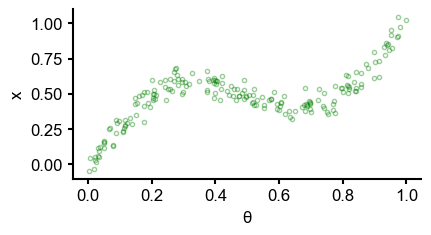

In [4]:
n = 200  # number of datapoints
d = 1  # dimensionality of parameter space theta

theta = torch.rand((n, d))  # uniform

noise = torch.randn((n, d)) * 0.05
x = theta + 0.3*torch.sin(2*pi*theta) + noise

# Data t_train and x_train
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none')
    plt.xlabel(r'$\theta$')
    plt.ylabel('x')
    plt.savefig("figures/2_1_cde/cde_samples_few.png", dpi=200, bbox_inches="tight")
    plt.show()

We want to train a neural network to predict $x$ from $\theta$.

<img src="figures/2_1_cde/neural_net_illustration.png" alt="drawing" width="1200"/> 

Taken from https://texample.net/tikz/examples/neural-network/

First, let's define our dataset:

In [5]:
dataset = data.TensorDataset(theta, x)
train_loader = data.DataLoader(dataset, batch_size=20)

Then, we build a neural network. The weights of this network will be optimized:

In [6]:
net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(),
    nn.Linear(20, 20), nn.ReLU(),
    nn.Linear(20, 1))

We define an optimizer which optimizes the weights (e.g. with gradient descent):

In [7]:
opt = optim.Adam(net.parameters(), lr=0.01)

Finally, we build a training loop where we optimize the weights with a Mean-Squared error loss:

In [8]:
for e in range(1000):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mse = (nn_output - x_batch)**2
        loss = mse.sum()
        loss.backward()
        opt.step()

Let's see if the neural network learned something...

### Evaluation of the neural network

Ask the neural network to predict $x$ for $100$ different values of $\theta$.

In [9]:
predictions = []
for t in torch.linspace(0, 1, 100):
    predictions.append(net(torch.as_tensor([t])))
predictions = torch.stack(predictions)

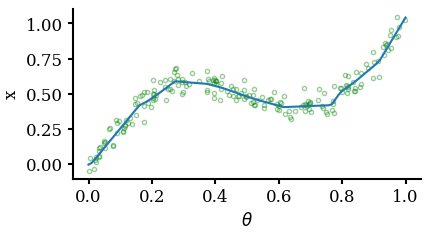

In [10]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none')
    plt.xlabel(r'$\theta$')
    plt.ylabel('x')
    plt.plot(np.linspace(0, 1, 100), predictions.detach().numpy())
    plt.savefig("figures/2_1_cde/nn_few.png", dpi=200, bbox_inches="tight")

# But now, on to the main part...

# Density estimation

Density estimation means to estimate the probability distribution $p(\theta)$ from samples $\theta_1, \theta_2, ...$.

<img src="figures/2_1_cde/species.png" alt="drawing" width="870"/>
Plot from https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html

There are many ways to do this:

- kernel density estimation
- non-parametric approaches with order statistics
- many neural network methods (GANs, VAEs, Normalizing flows,...)
- ...

Here, we will discuss (conditional) density estimation with Mixtures of Gaussians.

# Let's move to a simple example

In [11]:
mean = 1.0
std = 0.4

normal_dist = Normal(mean, std)  # We do not usually know this...
samples = normal_dist.sample((50,))  # ...but all we have are these samples.

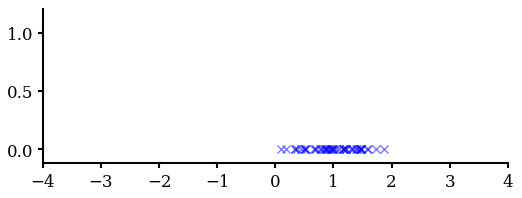

In [12]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none', markersize=6)
    _ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
    plt.savefig("figures/2_1_cde/samples.png", dpi=400, bbox_inches="tight")

Our goal is to estimate the underlying distribution of these samples.

# Fitting a Gaussian to data with maximum likelihood

### Learning mean and standard deviation

- Maximum likelihood: We maximize the likelihood of the samples {$\theta_1, \theta_2, ...$} under the model (i.e. the Gaussian)
- Assume that the data comes from a Normal (=Gaussian) distribution.
- All we want is to figure out the mean and the standard deviation.

$\mu', \sigma' = \text{argmax} p(\theta; \mu, \sigma) = \text{argmax}_{\mu, \sigma}\prod_i \mathcal{N}(\theta_i; \mu, \sigma)$

We can also find the minimum of the negative logarithm (becaus log is monotonic):

$\mu', \sigma' =  \text{argmin}_{\mu, \sigma} - \log \prod_i \mathcal{N}(\theta_i; \mu, \sigma) = \text{argmin}_{\mu, \sigma} - \sum_i \log \mathcal{N}(\theta_i; \mu, \sigma)$

# Exercise 1: Fitting a Gaussian to data with maximum likelihood

Your job: implement the probability of samples under a Gaussian model:
$p(\theta; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{(-\frac{(\mu-\theta)^2}{2\sigma^2})}$

Then train the model and check if the learned mean and std are around $(1.0, 0.4)$.

In [14]:
dataset = data.TensorDataset(samples)
train_loader = data.DataLoader(samples, batch_size=10)

learned_mean = torch.nn.Parameter(torch.zeros(1))
learned_log_std = torch.nn.Parameter(torch.zeros(1))

opt = optim.Adam([learned_mean, learned_log_std], lr=0.005)

for e in range(500):
    for sample_batch in samples:
        opt.zero_grad()
        learned_std = torch.exp(learned_log_std)
        ###################################################
        # Implement probability of sample_batch under a 
        # Gaussian with (mu, sigma) = (learned_mean, learned_std) 
        # prob_Gauss = ...
        loss = -torch.log(prob_Gauss).sum()
        loss.backward() 
        opt.step()

In [15]:
print("Learned mean: ", learned_mean.item(), ", learned standard deviation: ", torch.exp(learned_log_std).item())

Learned mean:  1.0079320669174194 , learned standard deviation:  0.4179263114929199


In [16]:
true_dist = Normal(mean, std)
learned_dist = Normal(learned_mean, torch.exp(learned_log_std))

In [17]:
x = torch.linspace(-4, 4, 100)
true_probs = torch.exp(normal_dist.log_prob(x))
learned_probs = torch.exp(learned_dist.log_prob(x)).detach()

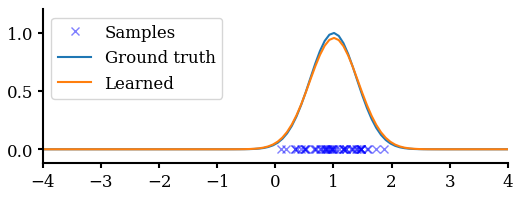

In [18]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none', markersize=6)
    plt.plot(x, true_probs)
    plt.plot(x, learned_probs)
    plt.legend(["Samples", "Ground truth", "Learned"], loc="upper left")
    _ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
    plt.savefig("figures/2_1_cde/fitted_samples.png", dpi=200, bbox_inches="tight")

# Exercise 2: Theory question

Why do we parameterize the logarithm of the standard deviation instead of the standard deviation itself?  

```python
learned_log_std = torch.nn.Parameter(torch.zeros(1))
# ...
for e in range(500):
    for batch in samples:
        learned_std = torch.exp(learned_log_std)
        prob_Gauss = 1/torch.sqrt(2*pi*learned_std**2) * exp(-.5/learned_std**2*(batch-learned_mean)**2)
        loss = -torch.log(prob_Gauss).sum()
```

# Summary of part 1: Density estimation

- goal is to identiy a probability distribution $p(\theta)$ from samples {$\theta_1, \theta_2,...$}.
- this is done by:
    - assuming a model, e.g. a Gaussian
    - learning its parameters with maximum likelihood $\text{argmax}_{\mu, \sigma} \prod_i p(\theta_i; \mu, \sigma)$
    - in practice, we minimize the negative log-likelihood

# Conditional density estimation

What is the probability of a taxi's drop-off location given the pick-up location?
<img src="figures/2_1_cde/taxi.png" alt="drawing" width="1500"/>  
We can model this with a conditional probability $p(\text{drop-off | pick-up = position}) = p(x | \theta)$

Image from Dutordoir et al. 2018

# Let's look at a simple model
Generate data from $x = \theta + 0.3 \sin(2 \pi t) + \epsilon$

In [19]:
# generate data
n = 4000  # number of datapoints
d = 1  # dimensionality of parameters theta

In [20]:
theta = torch.rand((n, d))

noise = torch.randn((n, d)) * 0.05
x = theta + 0.3*torch.sin(2*pi*theta) + noise

In [21]:
val_to_eval = torch.tensor(0.1)

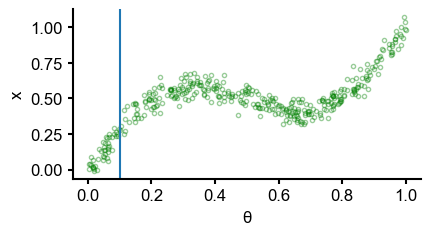

In [22]:
# Data t_train and x_train
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none')
    plt.axvline(val_to_eval.numpy())
    plt.xlabel(r'$\theta$')
    plt.ylabel('x')
    plt.savefig("figures/2_1_cde/cde_samples.png", dpi=200, bbox_inches="tight")
    plt.show()

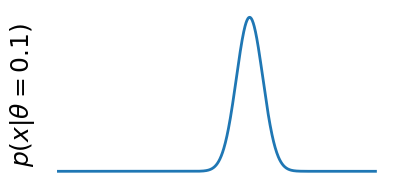

In [23]:
# Data t_train and x_train

mean = val_to_eval + 0.3*torch.sin(2*pi*val_to_eval)

with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.2))
    x_vals = torch.linspace(-0.2, 1.0, 1000)
    n = Normal(mean, 0.05)
    y_vals = n.log_prob(x_vals).exp().numpy()
    x_vals = x_vals.numpy()
    plt.plot(x_vals, np.flip(y_vals), linewidth=2)
    plt.xticks([])
    plt.yticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_ylabel(r"$p(x|\theta=0.1)$", rotation=90, fontsize=18)
    plt.savefig("figures/2_1_cde/conditional.png", dpi=300, bbox_inches="tight")

The goal is to estimate parameters of a conditional distribution:
<img src="figures/2_1_cde/cond_assembled.png" alt="drawing" width="1500"/>  

# How to do this?

We will assume that, **for a given $\theta$**, the probability density of $x$ is Gaussian, i.e.:

$p(x|\theta) = \mathcal{N}(x; \mu(\theta), \sigma(\theta))$

Importantly, the conditional mean $\mu(\theta)$ and the conditional st.dev. $\sigma(\theta)$ can be **non-linear functions** of $\theta$, i.e. 

$\mu = f(\theta)$  
$\sigma = g(\theta)$

<img src="figures/2_1_cde/nn.png" alt="drawing" width="2000"/>  

# Learning mean and standard deviation conditional on inputs

In [24]:
dataset = data.TensorDataset(theta, x)
train_loader = data.DataLoader(
    dataset, batch_size=20)

net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(),
    nn.Linear(20, 20), nn.ReLU(),
    nn.Linear(20, 2))

opt = optim.Adam(net.parameters(), lr=0.01)
for e in range(100):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:,1]).unsqueeze(1)
        prob_Gauss = 1/torch.sqrt(2*pi*std**2) * torch.exp(-.5/std**2*(mean-x_batch)**2)
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()

We now have a neural network which outputs the parameters of a probability density distribution given inputs.
In this case, it was a Gaussian distribution of which we learned the mean and standard deviation. To evaluate the result, we can look at samples from the returned distribution.

### Inspect the distribution for $\theta$ = 0.1

In [25]:
theta_test = tensor([0.1])  # the theta at which we evaluate the neural network.
nn_output = net(theta_test)
conditional_mean = nn_output[0].detach().numpy()
conditional_std = torch.exp(nn_output[1]).detach().numpy()
print("Conditional mean: ", conditional_mean, ", conditional std: ", conditional_std)

Conditional mean:  0.27525207 , conditional std:  0.053735852


/Users/deismic/anaconda3/envs/workshop/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/deismic/anaconda3/envs/workshop/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


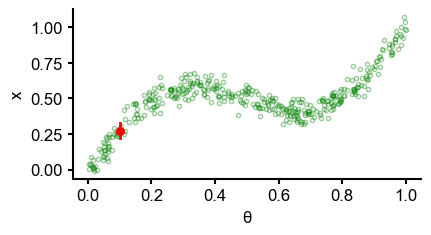

In [26]:
# Data t_train and x_train
with mpl.rc_context(fname=".matplotlibrc"):

    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none', zorder=-100)
    plt.plot([theta_test, theta_test], [conditional_mean-conditional_std, conditional_mean+conditional_std], c="r", linewidth=2)
    plt.scatter(theta_test, conditional_mean, c="r", s=30, alpha=1.0)
    plt.xlabel(r'$\theta$')
    plt.ylabel('x')
    plt.savefig("figures/2_1_cde/cde_fitted.png", dpi=200, bbox_inches="tight")
    plt.show()

# Exercise 3: Evaluate the NN for different values of $\theta$

Use the two cells above to evaluate the NN for other values of $\theta$, e.g. $\theta = 0.4$.

# Alternative evaluation: for every $\theta$, sample from the Gaussian

In [27]:
samples = []
theta_test = torch.linspace(0.0, 1.0, 500).unsqueeze(1)

for single_theta in theta_test:
    network_outs = net(single_theta.unsqueeze(1))
    m = network_outs[:,0]
    s = torch.exp(network_outs[:,1])
    conditional_distribution = Normal(m, s)
    sample = conditional_distribution.sample((1,))
    
    samples.append(sample)
samples = torch.cat(samples).data

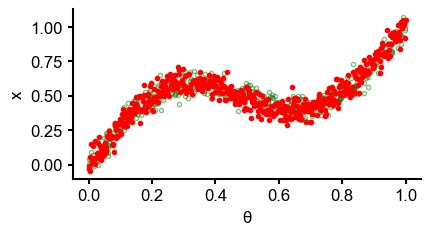

In [28]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(theta[:400], x[:400], 'go', alpha=0.5, markerfacecolor='none')
    plt.plot(theta_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
    plt.xlabel(r'$\theta$')
    plt.ylabel('x')
    # plt.savefig("data_prob_std_fit.png", dpi=200)
    plt.savefig("figures/2_1_cde/cde_fitted_samples.png", dpi=200, bbox_inches="tight")
    plt.show()

# Small detour
How does this relate to e.g. Bayesian linear regression?


<img src="figures/2_1_cde/bayes_lin_reg_assembled.png" alt="drawing" width="1500"/>  


# But what if the conditional distribution is not Gaussian?

Again, generate data from $x = \theta + 0.3 \sin(2 \pi \theta) + \epsilon$. But now, predict $\theta$ from $x$, i.e. learn $p(\theta | x)$.

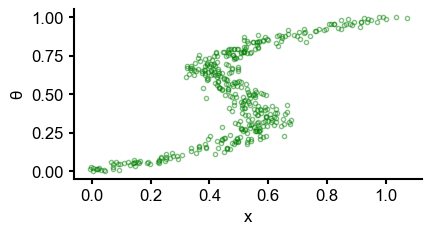

In [29]:
with mpl.rc_context(fname=".matplotlibrc"):

    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
    plt.xlabel('x')
    plt.ylabel(r'$\theta$')
    plt.savefig("figures/2_1_cde/cde_samples_inv.png", dpi=200, bbox_inches="tight")
    plt.show()

# Exercise 4: Your guesses.

What will the neural network predict for $x = 0.35$ ?

In [53]:
_ = torch.manual_seed(2)

### Let's train this just like before, but now predicting $\theta$ from $x$.

In [54]:
dataset = data.TensorDataset(x, theta)
train_loader = data.DataLoader(dataset, batch_size=20)

net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 2))

opt = optim.Adam(net.parameters(), lr=0.01)
for e in range(100):
    for x_batch, theta_batch in train_loader:
        opt.zero_grad()
        nn_output = net(x_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:,1]).unsqueeze(1)
        prob_Gauss = 1/torch.sqrt(2*pi*std**2) * torch.exp(-.5/std**2*(mean-theta_batch)**2)
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()

In [55]:
samples = []
x_test = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in x_test:
    network_outs = net(single_x.unsqueeze(1))
    mean = network_outs[:,0]
    std = torch.exp(network_outs[:,1])
    conditional_distribution = Normal(mean, std)
    sample = conditional_distribution.sample((1,))
    
    samples.append(sample)
samples = torch.cat(samples).data

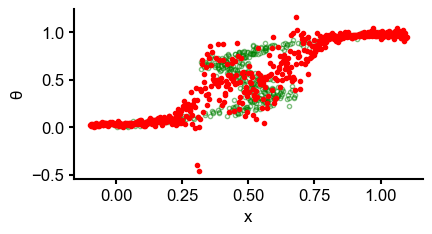

In [56]:
# plot
with mpl.rc_context(fname=".matplotlibrc"):

    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
    plt.plot(x_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
    plt.xlabel('x')
    plt.ylabel(r'$\theta$')
    plt.savefig("figures/2_1_cde/cde_fitted_inv_samples.png", dpi=200, bbox_inches="tight")
    plt.show()

# Okey, but how can we fix this?

# Mixture Density Networks
$$
$$
<img src="figures/2_1_cde/architecture.png" alt="drawing" width="1200"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$\mathcal{L} = -\sum_i \log q(\theta_i | x_i) = -\sum_i \log \sum_j \alpha_{j,i} \mathcal{N}(\theta_i; \mu_{j,i}(x_i), \sigma_{j,i}(x_i)$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

# Let's look at this in code!

In [43]:
class MultivariateGaussianMDN(nn.Module):
    def __init__(
        self,
        number_of_parameters, hidden_net,
        number_of_gaussians, hidden_features,
    ):
        super().__init__()
        self._number_of_parameters = number_of_parameters
        self._number_of_gaussians = number_of_gaussians
        
        self._hidden_net = hidden_net
        self._weights_layer = nn.Linear(hidden_features, number_of_gaussians)
        self._means_layer = nn.Linear(hidden_features, number_of_gaussians * number_of_parameters)
        self._log_variances_layer = nn.Linear(
            hidden_features, number_of_gaussians * number_of_parameters
        )

    def get_mixture_components(
        self, context
    ):
        h = self._hidden_net(context)

        weights_of_each_gaussian = self._weights_layer(h)
        weights_of_each_gaussian = weights_of_each_gaussian - torch.logsumexp(weights_of_each_gaussian, dim=1).unsqueeze(1)
        means = self._means_layer(h).view(-1, self._number_of_gaussians, self._number_of_parameters)

        log_variances = self._log_variances_layer(h).view(
            -1, self._number_of_gaussians, self._number_of_parameters
        )
        variances = torch.exp(log_variances)

        return weights_of_each_gaussian, means, variances

In [40]:
def mog_log_prob(theta, logits, means, variances):

    _, _, theta_dim = means.size()
    theta = theta.view(-1, 1, theta_dim)

    log_cov_det = -0.5*torch.log(torch.prod(variances, dim=2))

    a = logits
    b = -(theta_dim / 2.0) * log(2 * pi)
    c = log_cov_det
    d1 = theta.expand_as(means) - means
    precisions = 1.0 / variances
    exponent = torch.sum(d1 * precisions * d1, dim=2)
    exponent = tensor(-0.5) * exponent

    return torch.logsumexp(a + b + c + exponent, dim=-1)

# Exercise 5: Training the network

Your task is to train the neural network. You will have to use the above defined `mog_log_prob()` method to compute the log-probability of the parameters $\theta$ under a mixture of Gaussians with $(\alpha, \mu, \sigma^2)$.

In [47]:
_= torch.manual_seed(1)

In [48]:
dataset = data.TensorDataset(x, theta)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    number_of_parameters=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 30), nn.ReLU(),
        nn.Linear(30, 30), nn.ReLU(),
        nn.Linear(30, 30), nn.ReLU(),
    ),
    number_of_gaussians=5,
    hidden_features=30,
)
opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(200):
    for x_batch, theta_batch in train_loader:
        opt.zero_grad()
        weights_of_each_gaussian, means, variances = mdn.get_mixture_components(x_batch)
        ###################################################
        # Implement probability of `theta_batch` under a Mixture of Gaussians with (weights, means, variances).
        # Hint: use the `mog_log_prob` method defined in the cell above.
        # log_probs = ...
        loss = -log_probs.sum()
        loss.backward()
        opt.step()

# Let's evaluate this!

In [49]:
def mog_sample(logits, means, variances):

    coefficients = F.softmax(logits, dim=-1)
    choices = torch.multinomial(
        coefficients, num_samples=1, replacement=True
    ).view(-1)

    chosen_means = means[0, choices, :] # 0 for first batch position
    chosen_variances = variances[0, choices, :]

    _, _, output_dim = means.shape
    standard_normal_samples = torch.randn(output_dim)
    zero_mean_samples = standard_normal_samples * torch.sqrt(chosen_variances)
    samples = chosen_means + zero_mean_samples

    return samples

In [50]:
samples = []
x_test = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in x_test:
    weights, means, variances = mdn.get_mixture_components(single_x.unsqueeze(1))
    sample = mog_sample(weights, means, variances)
    
    samples.append(sample)
samples = torch.cat(samples).data

In [51]:
x_demo = torch.as_tensor([[0.6]])
logits, means, variances = mdn.get_mixture_components(x_demo)
demo_probs = []
for t_demo in torch.linspace(-0.1, 1., 100):
    prob = mog_log_prob(torch.as_tensor([t_demo]), logits, means, variances)
    demo_probs.append(prob)
demo_probs = torch.stack(demo_probs).detach().exp()

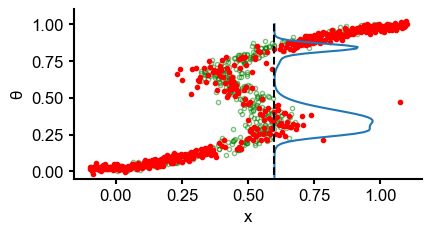

In [52]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(4.5, 2.2))
    plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
    plt.plot(x_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
    plt.plot(demo_probs.numpy()*0.1+x_demo.item(), np.linspace(-0.1, 1, 100))
    plt.plot([0.6]*100, np.linspace(-0.1, 1, 100), linestyle="--", color="k")
    plt.ylim([-0.05, 1.1])
    plt.xlabel('x')
    plt.ylabel(r'$\theta$')
    plt.savefig("figures/2_1_cde/cde_fitted_inv_samples_mdn.png", dpi=200, bbox_inches="tight")
    plt.show()

# Exercise 6: Evaluate the MoG for different values of $x$

Use the two cells above to inspect the distribution for different values of $x$.

# Example: estimating parameters of a neural circuit

We want to estimate the distribution of sodium and potassium conductances given an observed trace:

<img src="figures/2_1_cde/full_HH_fig.png" alt="drawing" width="1500"/>

# What are the limitations?
<br/>
- One has to decide on hyperparameters: e.g. how many components (i.e. Gaussians) will I need? <br/>
<br/>
- Training often does not converge perfectly. <br/>
<br/>
- In practice, high-dimensional distributions might not be captured perfectly even with a high number of components. <br/>
<br/>
- Normalizing flows, VAEs, and GANs are more flexible. However, Mixtures of Gaussians often allow for useful computations in closed form and are still sometimes used in practice.<br/>
<br/>

<img src="figures/2_1_cde/full_HH_fig.png" alt="drawing" width="1200"/>

## Summary: Conditional density estimation

- Density estimation means to estimate a probability distribution (=density) from samples. <br/>
<br/>
- Here, we assume a `model` (e.g. a Gaussian) and fit its parameters with maximum likelihood (i.e. maximizing the probability of the data under the model) <br/>
<br/>
- In conditional density estimation, we fit the parameters of a distribution given another quantity. <br/>
<br/>
- We can do this by regressing onto the parameters of the distribution with a neural network. <br/>
<br/>
- Mixture density networks predict parameters of a mixture of Gaussians <br/>
<br/>
- Because of this, this can capture variability and multi-modality <br/>
<br/>
- To look at their predictions, one can either draw samples from the predicted mixture of Gaussians or evaluate the probability of the prediction

# Acknowledgments
<br/>
<br/>

Parts of the code from: https://mikedusenberry.com/mixture-density-networks  <br/>
Code of MDNs based on Conor Durkan's `lfi` package.  <br/>
Bishop, 1994  <br/>
[MDN graphic](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)  
Pedro Gonçalves et al. for figure.